# Examples of Working with COGs

## Environment

The packages needed for this notebook can be installed with `conda` or `mamba`. Using the [`environment.yml` from this folder](./environment.yml) run:

```bash
conda env create -f environment.yml
```

or

```bash
mamba env create -f environment.yml
```

Finally, you may activate and select the kernel in the notebook (running in Jupyter)

```bash
conda activate coguide-cog
```

The notebook has been tested to work with the listed Conda environment.

## Setup

To demonstrate some COG concepts, we will download a regular GeoTIFF, create a Cloud-Optimized GeoTIFF, and explore their differences.

First, we use the [earthaccess](https://github.com/nsidc/earthaccess) library to set up credentials to fetch data from NASA's EarthData catalog.

In [1]:
import earthaccess
import rasterio
from rasterio.plot import show
from rio_cogeo import cog_validate, cog_info

/Users/kyle/local/micromamba/envs/coguide-cog/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
earthaccess.login()

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 10/24/2023
Using .netrc file for EDL


## Download a GeoTIFF from EarthData

Note: The whole point is that we _don't_ download data. So, in future examples, we will demonstrate how to access just subsets of data using COG and compare that with a GeoTIFF.

In [3]:
# Download data
short_name = 'VCF5KYR'
version = '001'

veg_item_results = earthaccess.search_data(
    short_name=short_name,
    version=version,
    count=1
)

Granules found: 33


In [4]:
test_data_dir = "./test_data"
veg_files = earthaccess.download(veg_item_results, test_data_dir)
veg_gtiff_filename = f"{test_data_dir}/{veg_files[0]}"

 Getting 1 granules, approx download size: 0.07 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 900.84it/s]


File VCF5KYR_1982001_001_2018224204211.tif already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 15887.52it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 29330.80it/s]


> To learn more about the example data see the [Vegetation Continuous Fields (VCF) information page](https://lpdaac.usgs.gov/products/vcf5kyrv001/).

## Is it a valid COG?

We can use `rio_cogeo.cog_validate` to check. It returns `is_valid`, `errors`, and `warnings`:

In [5]:
cog_validate(veg_gtiff_filename)

The following warnings were found:
- The file is greater than 512xH or 512xW, it is recommended to include internal overviews

The following errors were found:
- The file is greater than 512xH or 512xW, but is not tiled


(False,
 ['The file is greater than 512xH or 512xW, but is not tiled'],
 ['The file is greater than 512xH or 512xW, it is recommended to include internal overviews'])

Here's some more context on the output message:
    
1. `is_valid` is `False`: this is not a valid COG.
2. `errors` are `'The file is greater than 512xH or 512xW, but is not tiled'`. To be a valid COG, the file should be tiled since it has a height and width both greater than 512.
3. `warnings` are `'The file is greater than 512xH or 512xW, it is recommended to include internal overviews'`. It is recommended to provide overviews.

## Converting a GeoTIFF to COG

We can use `rio_cogeo.cog_create` to convert a GeoTIFF into a Cloud Optimized GeoTIFF:

In [6]:
veg_cog_filename = veg_gtiff_filename.replace(".tif", "_cog.tif")

!rio cogeo create {veg_gtiff_filename} {veg_cog_filename}

Reading input: /Users/kyle/ds/cloud-optimized-geospatial-formats-guide/cloud-optimized-geotiffs/test_data/VCF5KYR_1982001_001_2018224204211.tif
  [####################################]  100%
Adding overviews...
Updating dataset tags...
Writing output to: /Users/kyle/ds/cloud-optimized-geospatial-formats-guide/cloud-optimized-geotiffs/test_data/VCF5KYR_1982001_001_2018224204211_cog.tif


In [7]:
cog_validate(veg_cog_filename)

(True, [], [])

The file is a valid COG, so we will use it to compare with our GeoTIFF.

## Data Structure

**Dimensions**: the number of bands, rows, and columns stored in a GeoTIFF. [More Info](intro.qmd#dimensions)

**Internal Blocks (chunks or internal tiles)**: Internal blocks are required if the data dimensions are over 512x512. [More Info](intro.qmd#internal-blocks)

Let's check out the dimensions and blocks of our GeoTIFF and Cloud-Optimized GeoTIFF.

In [8]:
veg_gtiff_rio = rasterio.open(veg_gtiff_filename)
veg_cog_rio = rasterio.open(veg_cog_filename)

In [9]:
print(veg_gtiff_rio.shape)
veg_cog_rio.shape

(3600, 7200)


(3600, 7200)

They have the exact dimensions that we expected, which is good!

We can also print information about the GeoTIFF's IFD (Internal File Directory). Only one item is returned because the GeoTIFF needs overviews. We see more items returned when we print the IFD info for the COG, which has overviews.

In [10]:
cog_info(veg_gtiff_filename).IFD

[IFD(Level=0, Width=7200, Height=3600, Blocksize=(1, 7200), Decimation=0)]

In [11]:
cog_info(veg_cog_filename).IFD

[IFD(Level=0, Width=7200, Height=3600, Blocksize=(512, 512), Decimation=0),
 IFD(Level=1, Width=3600, Height=1800, Blocksize=(128, 128), Decimation=2),
 IFD(Level=2, Width=1800, Height=900, Blocksize=(128, 128), Decimation=4),
 IFD(Level=3, Width=900, Height=450, Blocksize=(128, 128), Decimation=8)]

Note for IFD Level 0, the regular GeoTIFF has a blocksize of `(1, 7200)` which implies each row of data is a separate block. So whenever reading in data, even if only a few columns are required, the full row must be read.

## Overviews

Overviews are downsampled (aggregated) data intended for visualization.

The most miniature size overview should match the tiling components’ fetch size, typically 256x256. Due to aspect ratio variation, aim to have at least one dimension at or slightly less than 256. 
> The COG driver in GDAL or rio cogeo tools should do this.

There are many resampling algorithms for generating overviews. The best resampling algorithm depends on the data's range, type, and distribution. When creating overviews, several options should be compared before deciding which resampling method to apply. 

GDAL >= 3.2 allows for the overview resampling method to be set directly.

In [12]:
veg_gtiff_rio.overviews(1)

[]

In [13]:
veg_cog_rio.overviews(1)

[2, 4, 8]

By displaying each overview, we can see how the dimensions get coarser for each overview level.

out height: 1800
out width: 3600


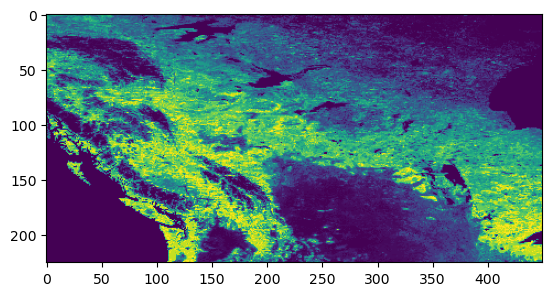

out height: 900
out width: 1800


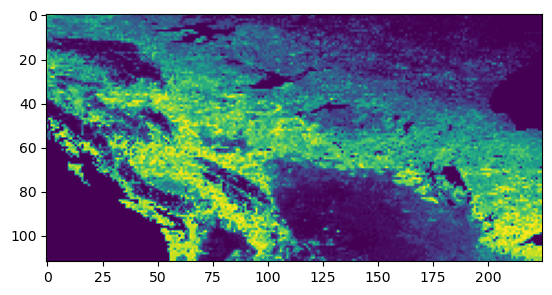

out height: 450
out width: 900


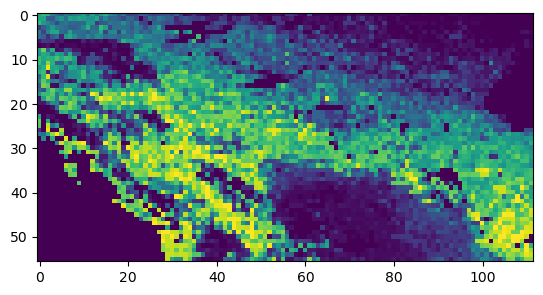

In [14]:
def show_overviews(geotiff):  
    for overview in geotiff.overviews(1):
        out_height = int(geotiff.height // overview)
        out_width = int(geotiff.width // overview)
        print(f"out height: {out_height}")
        print(f"out width: {out_width}")    
        # read first band of file and set shape of new output array
        window_size_height = round(out_height/8)
        window_size_width = round(out_width/8)
        image = veg_cog_rio.read(1, out_shape=(1, out_height, out_width))[
            window_size_height:(window_size_height*2),
            window_size_width:(window_size_width*2),
        ]
        show(image)
        
show_overviews(veg_cog_rio)

We can generate more and different overviews, through different tilesizes and resampling.

In [15]:
import gen_overviews

In [16]:
tmp_dst = gen_overviews.create_overviews_from_gtiff(veg_gtiff_rio)
tmp_cog = rasterio.open(tmp_dst)
cog_info(tmp_dst).IFD

[IFD(Level=0, Width=7200, Height=3600, Blocksize=(1, 7200), Decimation=0),
 IFD(Level=1, Width=3600, Height=1800, Blocksize=(128, 128), Decimation=2),
 IFD(Level=2, Width=1800, Height=900, Blocksize=(128, 128), Decimation=4),
 IFD(Level=3, Width=900, Height=450, Blocksize=(128, 128), Decimation=8),
 IFD(Level=4, Width=450, Height=225, Blocksize=(128, 128), Decimation=16)]

Note: Now we have overviews but there are still no tiles on the Level 0 IFD.

In [17]:
overviews = tmp_cog.overviews(1)
overviews

[2, 4, 8, 16]

out height: 1800
out width: 3600


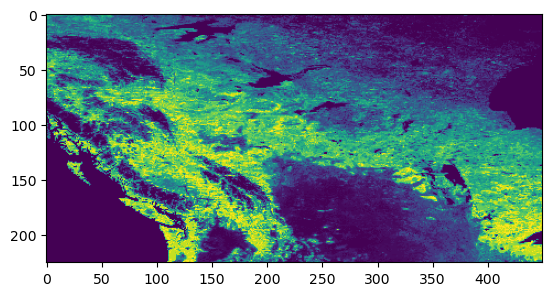

out height: 900
out width: 1800


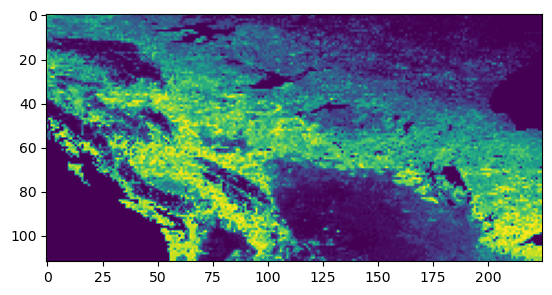

out height: 450
out width: 900


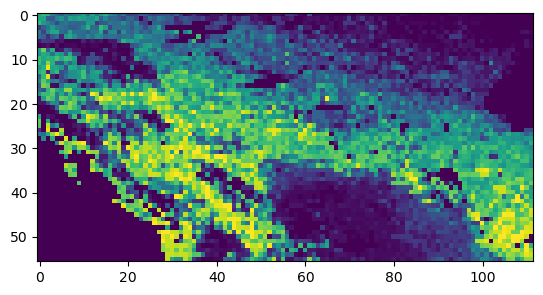

out height: 225
out width: 450


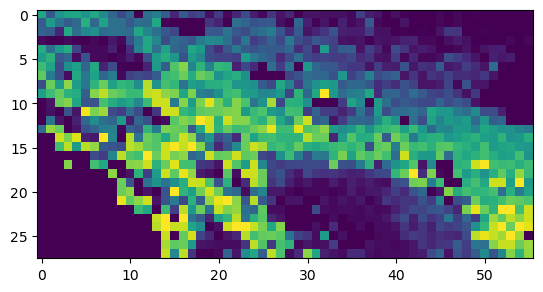

In [18]:
show_overviews(tmp_cog)